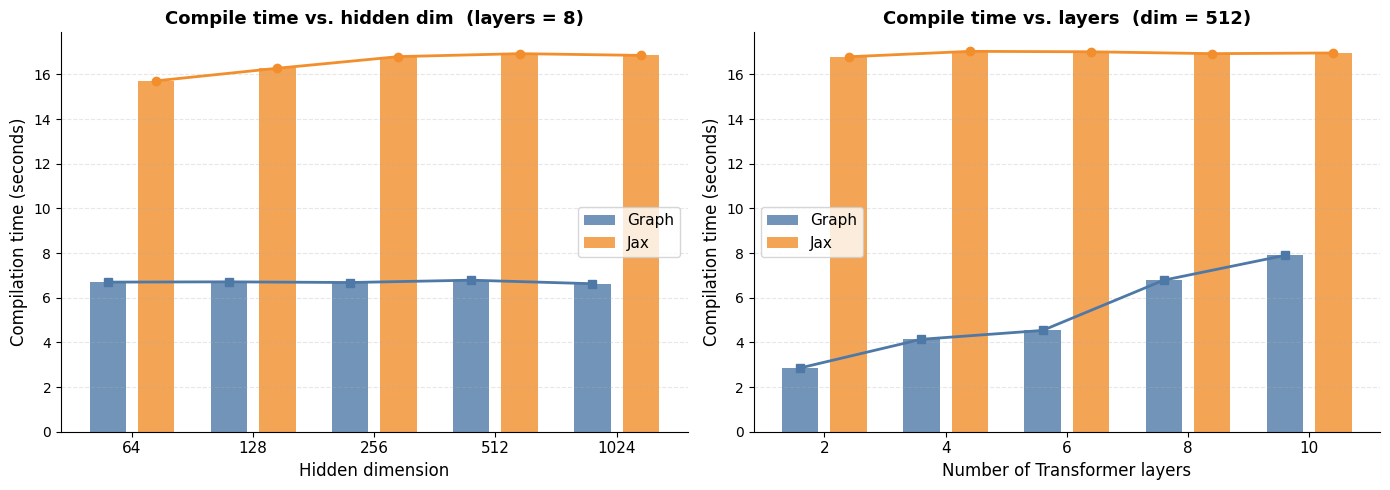

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatter, MaxNLocator

# ──────────────────────────────────────────────────────────────
# 1. Load & tag implementations
# ──────────────────────────────────────────────────────────────
jax   = pd.read_csv('./profile_tempo_on_llama.csv')
graph = pd.read_csv('../collected_data/profile_graph_generation.csv')

jax  ['impl'] = 'jax'
graph['impl'] = 'graph'

# ──────────────────────────────────────────────────────────────
# 2. Exact filters you specified
# ──────────────────────────────────────────────────────────────
COMMON = dict(batch_size=16, seq_len=60, n_heads=4)

# Panel A : vary dim  (layers = 8)
cfgA_jax   = {**COMMON, 'prompt_len': 20, 'n_layers': 8}
cfgA_graph = {**COMMON,                 'n_layers': 8}

dfA = pd.concat([
    jax  .query(' & '.join(f'{k} == {v}' for k, v in cfgA_jax.items())),
    graph.query(' & '.join(f'{k} == {v}' for k, v in cfgA_graph.items()))
])

# Panel B : vary layers (dim = 512)
cfgB_jax   = {**COMMON, 'prompt_len': 20, 'dim': 512}
cfgB_graph = {**COMMON,                 'dim': 512}

dfB = pd.concat([
    jax  .query(' & '.join(f'{k} == {v}' for k, v in cfgB_jax.items())),
    graph.query(' & '.join(f'{k} == {v}' for k, v in cfgB_graph.items()))
])

# ──────────────────────────────────────────────────────────────
# 3. Pretty bar + line helper with explicit bar-gap & log toggle
# ──────────────────────────────────────────────────────────────
COLORS  = {'graph': '#4E79A7', 'jax': '#F28E2B'}   # blue / orange
MARKERS = {'graph': 's',        'jax': 'o'}

def pretty_panel(ax, data, *, x_col, x_label, title, log_scale=True):
    """Draw one panel with a gap between the two bars in each group."""
    # average duplicates then pivot
    piv = (data
           .pivot_table(index=x_col, columns='impl',
                        values='compile_s', aggfunc='mean')
           .sort_index())

    x_vals = piv.index.to_list()
    x_pos  = np.arange(len(x_vals))
    impls  = piv.columns.to_list()          # ['graph', 'jax']

    # geometry: total group width 0.8 = bar*2 + gap
    bar_w   = 0.3
    gap_w   = 0.1
    offsets = (-bar_w/2 - gap_w/2, bar_w/2 + gap_w/2)  # graph left, jax right

    for impl, off in zip(impls, offsets):
        y = piv[impl].values
        ax.bar(x_pos + off, y,
               width=bar_w,
               color=COLORS[impl],
               alpha=0.8,
               label=impl.capitalize())
        ax.plot(x_pos + off, y,
                marker=MARKERS[impl],
                linestyle='-',
                color=COLORS[impl],
                linewidth=2,
                markersize=6)

    # axis cosmetics
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_vals, fontsize=11)

    if log_scale:
        ax.set_yscale('log')
        ax.yaxis.set_major_locator(LogLocator(base=10))
        ax.yaxis.set_major_formatter(LogFormatter(base=10, labelOnlyBase=False))
    else:
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    ax.grid(axis='y', which='both', linestyle='--', alpha=0.3)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel('Compilation time (seconds)', fontsize=12)
    ax.set_title(title, fontsize=13, weight='bold')
    ax.legend(frameon=True, fontsize=11)

# ──────────────────────────────────────────────────────────────
# 4. Draw the figure
# ──────────────────────────────────────────────────────────────
plt.rcParams.update({'axes.spines.right': False, 'axes.spines.top': False})

fig, (axL, axR) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
fig.subplots_adjust(wspace=0.3)

pretty_panel(axL, dfA, x_col='dim',
             x_label='Hidden dimension',
             title='Compile time vs. hidden dim  (layers = 8)',
             log_scale=False)
axR.tick_params(axis='y', labelleft=True)

pretty_panel(axR, dfB, x_col='n_layers',
             x_label='Number of Transformer layers',
             title='Compile time vs. layers  (dim = 512)',
             log_scale=False)

plt.tight_layout()
plt.show()


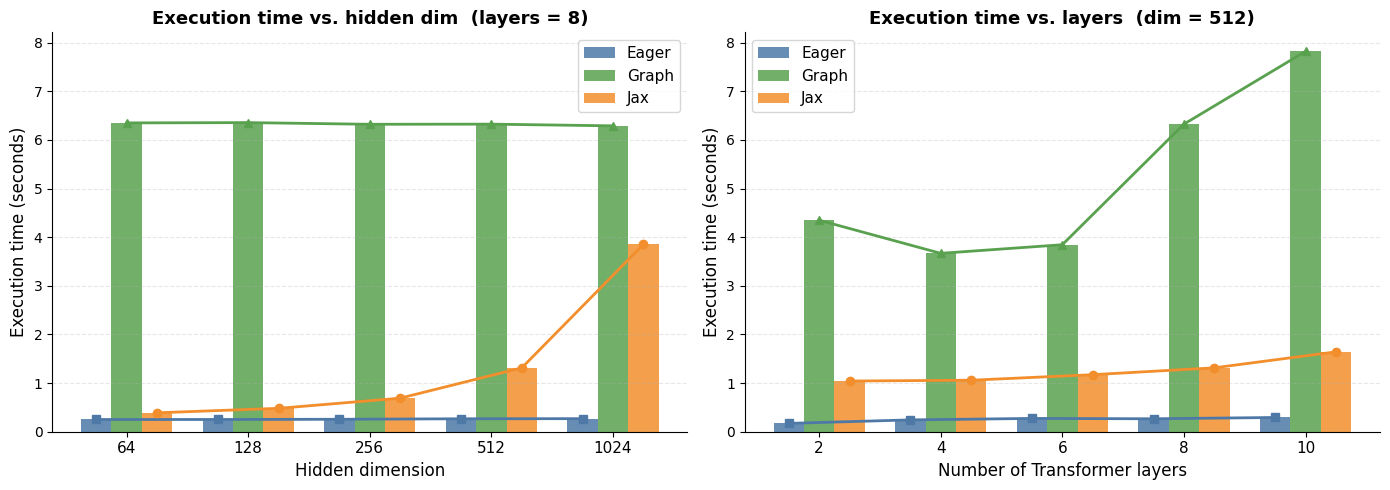

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatter, MaxNLocator

# ──────────────────────────────────────────────────────────────
# 1. Load CSVs and tag implementations
# ──────────────────────────────────────────────────────────────
jax   = pd.read_csv('./profile_tempo_on_llama.csv')
graph = pd.read_csv('../collected_data/profile_graph_generation.csv')
eager = pd.read_csv('../collected_data/profile_eager_generation.csv')

jax  ['impl'] = 'jax'
graph['impl'] = 'graph'
eager['impl'] = 'eager'

def q(expr_cfg):
    """Utility to turn the dict into a query string."""
    return ' & '.join(f'{k} == {v}' for k, v in expr_cfg.items())

# ──────────────────────────────────────────────────────────────
# 2. Filters for the two sweeps
# ──────────────────────────────────────────────────────────────
COMMON = dict(batch_size=16, seq_len=60, n_heads=4)

# ── Panel A : vary dim  (layers = 8) ────────────────────────────────
cfgA = {**COMMON, 'prompt_len': 20, 'n_layers': 8}
dfA  = pd.concat([
    jax  .query(q(cfgA)),
    graph.query(q({**COMMON, 'n_layers': 8})),   # ← no prompt_len here
    eager.query(q({**COMMON, 'n_layers': 8}))
])

# ── Panel B : vary layers (dim = 512) ──────────────────────────────
cfgB = {**COMMON, 'prompt_len': 20, 'dim': 512}
dfB  = pd.concat([
    jax  .query(q(cfgB)),
    graph.query(q({**COMMON, 'dim': 512})),      # ← no prompt_len here
    eager.query(q({**COMMON, 'dim': 512}))
])

# ──────────────────────────────────────────────────────────────
# 3. Bar-plus-line helper (handles gaps & duplicates)
# ──────────────────────────────────────────────────────────────
COLORS  = {'eager': '#4E79A7', 'jax': '#F28E2B', 'graph': '#59A14F'}
MARKERS = {'eager': 's',        'jax': 'o',        'graph': '^'}

def exec_panel(ax, data, *, x_col, x_label, title, log_scale=True):
    # collapse duplicates, pivot rows = x, cols = impl
    piv = (data
           .pivot_table(index=x_col, columns='impl',
                        values='exec_s', aggfunc='mean')
           .sort_index())

    x_vals = piv.index.to_list()
    x_pos  = np.arange(len(x_vals))
    impls  = piv.columns.to_list()          # eager / graph / jax

    # each bar width 0.25, leave a 0.1 gap on both ends
    bar_w   = 0.25
    step    = bar_w
    offsets = (np.arange(len(impls)) - (len(impls)-1)/2) * step

    for impl, off in zip(impls, offsets):
        y = piv[impl].values
        ax.bar(x_pos + off, y,
               width=bar_w,
               color=COLORS[impl],
               alpha=0.85,
               label=impl.capitalize())
        ax.plot(x_pos + off, y,
                marker=MARKERS[impl],
                linestyle='-',
                color=COLORS[impl],
                linewidth=2,
                markersize=6)

    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_vals, fontsize=11)

    if log_scale:
        ax.set_yscale('log')
        ax.yaxis.set_major_locator(LogLocator(base=10))
        ax.yaxis.set_major_formatter(LogFormatter(base=10, labelOnlyBase=False))
    else:
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    ax.grid(axis='y', which='both', linestyle='--', alpha=0.3)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel('Execution time (seconds)', fontsize=12)
    ax.set_title(title, fontsize=13, weight='bold')
    ax.legend(frameon=True, fontsize=11)

# ──────────────────────────────────────────────────────────────
# 4. Draw the figure
# ──────────────────────────────────────────────────────────────
plt.rcParams.update({'axes.spines.right': False, 'axes.spines.top': False})

fig, (axL, axR) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
fig.subplots_adjust(wspace=0.32)

exec_panel(axL, dfA,
           x_col='dim',
           x_label='Hidden dimension',
           title='Execution time vs. hidden dim  (layers = 8)',
           log_scale=False)

exec_panel(axR, dfB,
           x_col='n_layers',
           x_label='Number of Transformer layers',
           title='Execution time vs. layers  (dim = 512)',
           log_scale=False)

# show y-tick labels on both shared-axis panels
axR.tick_params(axis='y', labelleft=True)

plt.tight_layout()
plt.show()


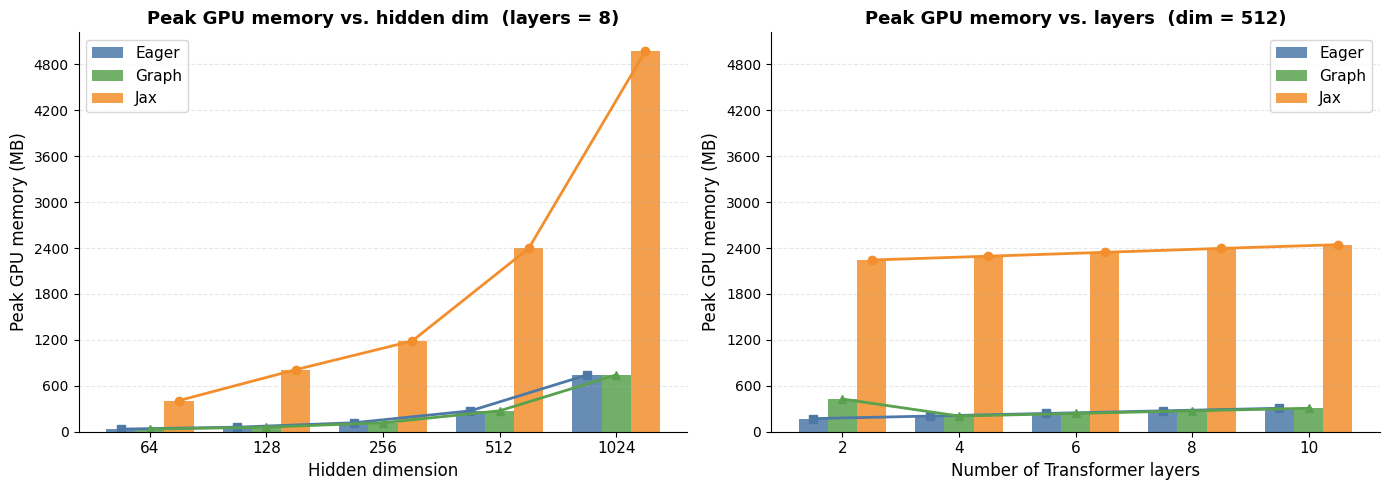

In [49]:
# ──────────────────────────────────────────────────────────────
# Compare peak GPU memory usage (MB)
# ──────────────────────────────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatter, MaxNLocator

def mem_panel(ax, data, *, x_col, x_label, title, log_scale=False):
    """Bar-plus-line chart for peak GPU memory."""
    piv = (data
           .pivot_table(index=x_col, columns='impl',
                        values='peak_gpu_MB', aggfunc='mean')
           .sort_index())

    x_vals = piv.index.to_list()
    x_pos  = np.arange(len(x_vals))
    impls  = piv.columns.to_list()           # eager / graph / jax

    # bar placement: width 0.25 with equal offsets
    bar_w   = 0.25
    step    = bar_w
    offsets = (np.arange(len(impls)) - (len(impls)-1)/2) * step

    for impl, off in zip(impls, offsets):
        y = piv[impl].values
        ax.bar(x_pos + off, y,
               width=bar_w,
               color=COLORS[impl],
               alpha=0.85,
               label=impl.capitalize())
        ax.plot(x_pos + off, y,
                marker=MARKERS[impl],
                linestyle='-',
                color=COLORS[impl],
                linewidth=2,
                markersize=6)

    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_vals, fontsize=11)

    if log_scale:
        ax.set_yscale('log')
        ax.yaxis.set_major_locator(LogLocator(base=10))
        ax.yaxis.set_major_formatter(LogFormatter(base=10, labelOnlyBase=False))
    else:
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    ax.grid(axis='y', which='both', linestyle='--', alpha=0.3)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel('Peak GPU memory (MB)', fontsize=12)
    ax.set_title(title, fontsize=13, weight='bold')
    ax.legend(frameon=True, fontsize=11)

# ──────────────────────────────────────────────────────────────
# Draw the figure
# ──────────────────────────────────────────────────────────────
plt.rcParams.update({'axes.spines.right': False, 'axes.spines.top': False})

fig, (axL, axR) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
fig.subplots_adjust(wspace=0.32)

mem_panel(axL, dfA,
          x_col='dim',
          x_label='Hidden dimension',
          title='Peak GPU memory vs. hidden dim  (layers = 8)',
          log_scale=False)

mem_panel(axR, dfB,
          x_col='n_layers',
          x_label='Number of Transformer layers',
          title='Peak GPU memory vs. layers  (dim = 512)',
          log_scale=False)

# show y-tick labels on both shared-axis panels
axR.tick_params(axis='y', labelleft=True)

plt.tight_layout()
plt.show()


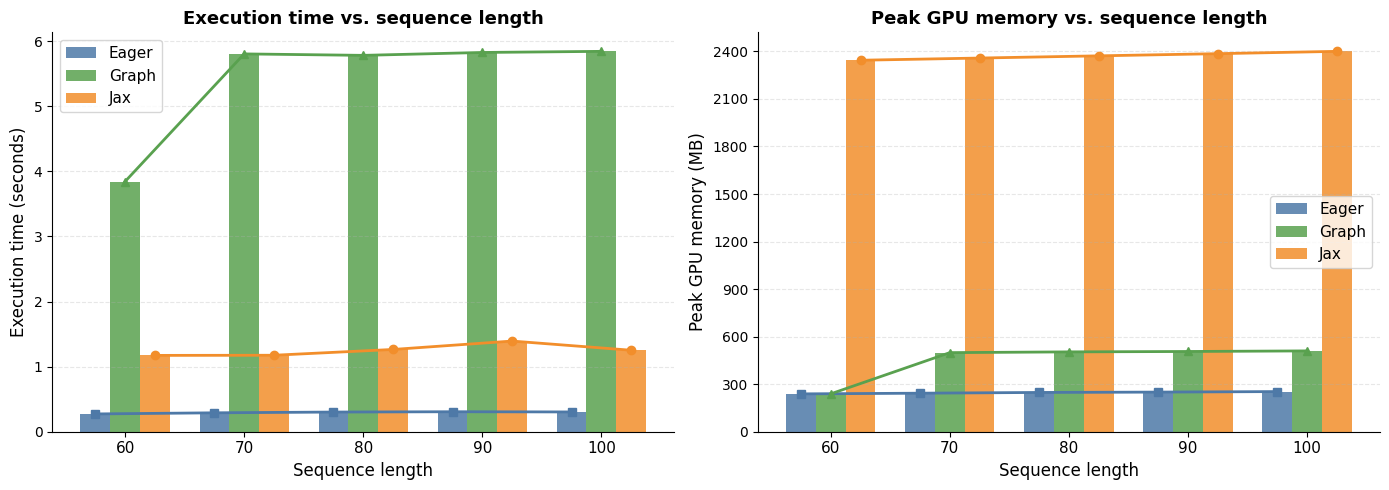

In [50]:
# ──────────────────────────────────────────────────────────────
# Effect of sequence length (dim=512, batch=16, prompt_len=20,
#                            n_layers=6, n_heads=4)
# ──────────────────────────────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatter, MaxNLocator

# helper used earlier
def q(cfg):
    return ' & '.join(f'{k} == {v}' for k, v in cfg.items())

# build the filtered dataframe
FIXED = dict(dim=512, batch_size=16, n_layers=6, n_heads=4)

df_seq = pd.concat([
    jax  .query(q({**FIXED, 'prompt_len': 20})),  # jax has prompt_len
    graph.query(q(FIXED)),                        # graph / eager do not
    eager.query(q(FIXED))
])

# ──────────────────────────────────────────────────────────────
# Draw figure: execution‑time panel + memory‑panel
# (re‑uses exec_panel and mem_panel defined earlier)
# ──────────────────────────────────────────────────────────────
plt.rcParams.update({'axes.spines.right': False, 'axes.spines.top': False})

fig, (axT, axM) = plt.subplots(1, 2, figsize=(14, 5))
fig.subplots_adjust(wspace=0.32)

exec_panel(axT, df_seq,
           x_col='seq_len',
           x_label='Sequence length',
           title='Execution time vs. sequence length',
           log_scale=False)

mem_panel(axM, df_seq,
          x_col='seq_len',
          x_label='Sequence length',
          title='Peak GPU memory vs. sequence length',
          log_scale=False)

plt.tight_layout()
plt.show()


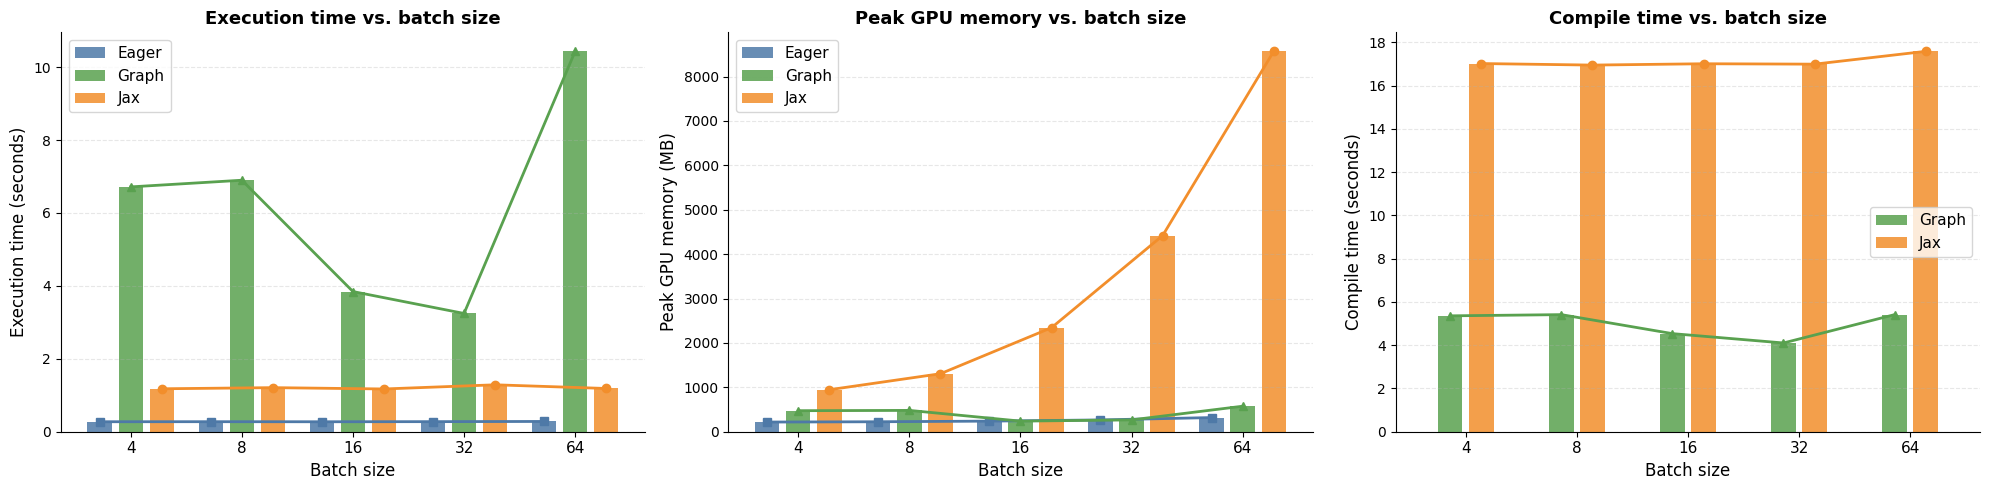

In [51]:
# ──────────────────────────────────────────────────────────────
# Batch-size sweep ─ 3 panels: exec, memory, compile
# ----------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatter, MaxNLocator

# ▸ tweak these if you want
bar_width = 0.22     # width of each bar
gap_width = 0.06     # gap between bars within a group

# ----------------------------------------------------------------
def q(cfg):                                   # dict → query string
    return ' & '.join(f'{k} == {v}' for k, v in cfg.items())

# slice: vary batch_size, keep all else fixed (see sweep scripts)
FIXED = dict(dim=512, n_layers=6, seq_len=60, n_heads=4)

df_bsz = pd.concat([
    jax  .query(q({**FIXED, 'prompt_len': 20})),   # jax has prompt_len
    graph.query(q(FIXED)),
    eager.query(q(FIXED))
])

# ----------------------------------------------------------------
# generic bar-with-line helper (inherits bar_width / gap_width)
def _panel(ax, data, y_col, *, y_label, title,
           x_col='batch_size', x_label='Batch size',
           log_scale=False, bar_width=bar_width, gap_width=gap_width):

    piv = (data.pivot_table(index=x_col, columns='impl',
                            values=y_col, aggfunc='mean')
               .sort_index())

    x_vals = piv.index.to_list()
    x_pos  = np.arange(len(x_vals))
    impls  = piv.columns.to_list()

    step    = bar_width + gap_width
    offsets = (np.arange(len(impls)) - (len(impls)-1)/2) * step

    for impl, off in zip(impls, offsets):
        y = piv[impl].values
        ax.bar(x_pos + off, y,
               width=bar_width,
               color=COLORS[impl],
               alpha=0.85,
               label=impl.capitalize())
        ax.plot(x_pos + off, y,
                marker=MARKERS[impl],
                linestyle='-',
                color=COLORS[impl],
                linewidth=2,
                markersize=6)

    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_vals, fontsize=11)

    if log_scale:
        ax.set_yscale('log')
        ax.yaxis.set_major_locator(LogLocator(base=10))
        ax.yaxis.set_major_formatter(LogFormatter(base=10, labelOnlyBase=False))
    else:
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    ax.grid(axis='y', which='both', linestyle='--', alpha=0.3)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_title(title, fontsize=13, weight='bold')
    ax.legend(frameon=True, fontsize=11)

# ----------------------------------------------------------------
# Draw the 3-panel figure
# ----------------------------------------------------------------
plt.rcParams.update({'axes.spines.right': False, 'axes.spines.top': False})

fig, (axE, axM, axC) = plt.subplots(1, 3, figsize=(20, 5), sharex=True)
fig.subplots_adjust(wspace=0.32)

# execution time
_panel(axE, df_bsz, 'exec_s',
       y_label='Execution time (seconds)',
       title='Execution time vs. batch size')

# peak memory
_panel(axM, df_bsz, 'peak_gpu_MB',
       y_label='Peak GPU memory (MB)',
       title='Peak GPU memory vs. batch size')

# compile time – ignore eager
_panel(axC, df_bsz[df_bsz['impl'] != 'eager'], 'compile_s',
       y_label='Compile time (seconds)',
       title='Compile time vs. batch size')

plt.tight_layout()
plt.show()
